# League of Legends Match Predictor

### Project introduction <br/>
LeLeague of Legends, a popular multiplayer online battle arena (MOBA) game, generates extensive data from matches, providing an excellent opportunity to apply machine learning techniques to real-world scenarios. I will be building a logistic regression model aimed at predicting the outcomes of League of Legends matches.  

Use the [league_of_legends_data_large.csv](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rk7VDaPjMp1h5VXS-cUyMg/league-of-legends-data-large.csv) file to perform the tasks. 

In [37]:
import pandas as pd  # Import pandas for data manipulation
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for feature scaling
import torch  # Import torch for tensor operations

data = pd.read_csv('league_of_legends_data_large.csv')  # Load the dataset into a pandas DataFrame

X = data.drop('win', axis=1)  # Separate features by dropping the 'win' column
y = data['win']  # Set the target variable as the 'win' column

X_train, X_test, y_train, y_test = train_test_split(  # Split data into training and testing sets
    X, y, test_size=0.2, random_state=42)  # Use 80% for training, 20% for testing, set random_state for reproducibility

scaler = StandardScaler()  # Create a StandardScaler instance for feature normalization
X_train = scaler.fit_transform(X_train)  # Fit the scaler on training data and transform it
X_test = scaler.transform(X_test)  # Transform the test data using the scaler fitted on training data

X_train = torch.tensor(X_train, dtype=torch.float32)  # Convert training features to PyTorch tensor (float32)
X_test = torch.tensor(X_test, dtype=torch.float32)  # Convert test features to PyTorch tensor (float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)  # Convert training labels to PyTorch tensor (float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)  # Convert test labels to PyTorch tensor (float32)

In [38]:
import torch.nn as nn  # Import torch.nn for neural network modules

class LogisticRegressionModel(nn.Module):  # Define a class for the logistic regression model
    def __init__(self, input_dim):  # Constructor takes input_dim (number of features)
        super(LogisticRegressionModel, self).__init__()  # Call the parent class constructor
        self.linear = nn.Linear(input_dim, 1)  # Single linear layer for logistic regression

    def forward(self, x):  # Define the forward pass
        return torch.sigmoid(self.linear(x))  # Apply sigmoid activation to linear output

input_dim = X_train.shape[1]  # Get the number of features from training data

model = LogisticRegressionModel(input_dim)  # Instantiate the logistic regression model
criterion = nn.BCELoss()  # Use binary cross-entropy loss for binary classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Use SGD optimizer with learning rate 0.01

In [39]:
epochs = 1000  # Set the number of training epochs

for epoch in range(epochs):  # Loop over the number of epochs
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero the gradients before each batch
    outputs = model(X_train).squeeze()  # Forward pass: get model predictions for training data
    loss = criterion(outputs, y_train)  # Compute the loss between predictions and true labels
    loss.backward()  # Backpropagation: compute gradients
    optimizer.step()  # Update model parameters using gradients

    if (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    train_preds = (model(X_train).squeeze() >= 0.5).float()  # Predict on training set (threshold 0.5)
    train_acc = (train_preds == y_train).float().mean().item()  # Calculate training accuracy

    test_preds = (model(X_test).squeeze() >= 0.5).float()  # Predict on test set (threshold 0.5)
    test_acc = (test_preds == y_test).float().mean().item()  # Calculate test accuracy

print(f"Training Accuracy: {train_acc * 100:.2f}%")  # Print training accuracy
print(f"Test Accuracy: {test_acc * 100:.2f}%")  # Print test accuracy

Epoch [100/1000], Loss: 0.7445
Epoch [200/1000], Loss: 0.7240
Epoch [300/1000], Loss: 0.7103
Epoch [400/1000], Loss: 0.7013
Epoch [500/1000], Loss: 0.6955
Epoch [600/1000], Loss: 0.6918
Epoch [700/1000], Loss: 0.6894
Epoch [800/1000], Loss: 0.6879
Epoch [900/1000], Loss: 0.6869
Epoch [1000/1000], Loss: 0.6863
Training Accuracy: 54.12%
Test Accuracy: 48.50%


In [40]:
model_l2 = LogisticRegressionModel(input_dim)  # Re-instantiate the model for L2 regularization
optimizer_l2 = torch.optim.SGD(model_l2.parameters(), lr=0.01, weight_decay=0.01)  # Add weight_decay for L2

for epoch in range(epochs):  # Loop over epochs
    model_l2.train()  # Set model to training mode
    optimizer_l2.zero_grad()  # Zero the gradients
    outputs = model_l2(X_train).squeeze()  # Forward pass
    loss = criterion(outputs, y_train)  # Compute loss
    loss.backward()  # Backpropagation
    optimizer_l2.step()  # Update parameters

    if (epoch + 1) % 100 == 0:  # Print loss every 100 epochs
        print(f"[L2] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

model_l2.eval()  # Set model to evaluation mode
with torch.no_grad():  # No gradients needed for evaluation
    train_preds_l2 = (model_l2(X_train).squeeze() >= 0.5).float()  # Predict on training set
    train_acc_l2 = (train_preds_l2 == y_train).float().mean().item()  # Training accuracy
    test_preds_l2 = (model_l2(X_test).squeeze() >= 0.5).float()  # Predict on test set
    test_acc_l2 = (test_preds_l2 == y_test).float().mean().item()  # Test accuracy

print(f"[L2] Training Accuracy: {train_acc_l2 * 100:.2f}%")  # Print L2 training accuracy
print(f"[L2] Test Accuracy: {test_acc_l2 * 100:.2f}%")  # Print L2 test accuracy

[L2] Epoch [100/1000], Loss: 0.7167
[L2] Epoch [200/1000], Loss: 0.7043
[L2] Epoch [300/1000], Loss: 0.6968
[L2] Epoch [400/1000], Loss: 0.6923
[L2] Epoch [500/1000], Loss: 0.6895
[L2] Epoch [600/1000], Loss: 0.6879
[L2] Epoch [700/1000], Loss: 0.6869
[L2] Epoch [800/1000], Loss: 0.6863
[L2] Epoch [900/1000], Loss: 0.6859
[L2] Epoch [1000/1000], Loss: 0.6857
[L2] Training Accuracy: 55.12%
[L2] Test Accuracy: 50.50%


Confusion Matrix:
 [[37 58]
 [41 64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.39      0.43        95
           1       0.52      0.61      0.56       105

    accuracy                           0.51       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.51      0.50       200



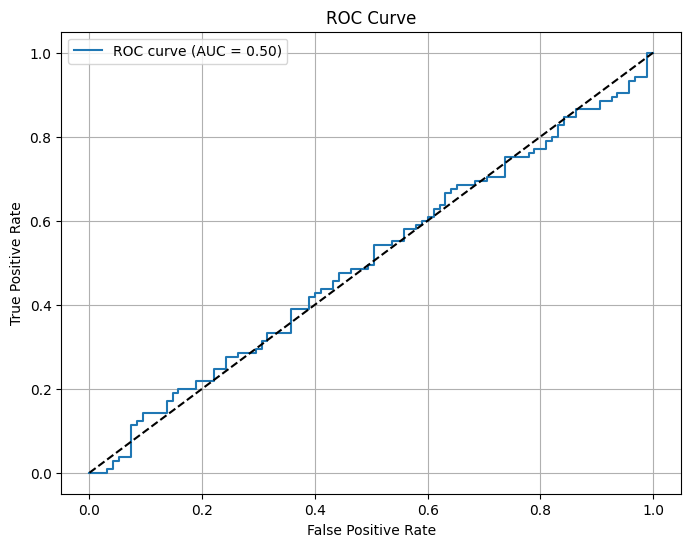

In [41]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report  # Import metrics for evaluation
import matplotlib.pyplot as plt  # Import matplotlib for plotting

with torch.no_grad():  # No gradients needed for evaluation
    test_probs = model_l2(X_test).squeeze().numpy()  # Get predicted probabilities for ROC
    test_preds = (test_probs >= 0.5).astype(int)  # Get binary predictions
    y_test_np = y_test.numpy().astype(int)  # Convert test labels to numpy array

cm = confusion_matrix(y_test_np, test_preds)  # Compute confusion matrix
print("Confusion Matrix:\n", cm)  # Print confusion matrix

print("Classification Report:\n", classification_report(y_test_np, test_preds))  # Print classification report

fpr, tpr, thresholds = roc_curve(y_test_np, test_probs)  # Compute ROC curve
roc_auc = auc(fpr, tpr)  # Compute AUC

plt.figure(figsize=(8, 6))  # Set figure size
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')  # Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')  # X-axis label
plt.ylabel('True Positive Rate')  # Y-axis label
plt.title('ROC Curve')  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display plot

In [42]:
torch.save(model_l2.state_dict(), 'lol_logreg_model.pth')  # Save the model's state_dict to a file

loaded_model = LogisticRegressionModel(input_dim)  # Create a new model instance
loaded_model.load_state_dict(torch.load('lol_logreg_model.pth'))  # Load the saved parameters
loaded_model.eval()  # Set the loaded model to evaluation mode

with torch.no_grad():  # No gradients needed for evaluation
    loaded_test_preds = (loaded_model(X_test).squeeze() >= 0.5).float()  # Predict on test set
    loaded_test_acc = (loaded_test_preds == y_test).float().mean().item()  # Calculate accuracy

print(f"Loaded Model Test Accuracy: {loaded_test_acc * 100:.2f}%")  # Print loaded model accuracy

Loaded Model Test Accuracy: 50.50%


In [43]:
learning_rates = [0.01, 0.05, 0.1]  # List of learning rates to try
best_acc = 0  # Track best accuracy
best_lr = None  # Track best learning rate

for lr in learning_rates:  # Loop over each learning rate
    model_tune = LogisticRegressionModel(input_dim)  # New model for each learning rate
    optimizer_tune = torch.optim.SGD(model_tune.parameters(), lr=lr, weight_decay=0.01)  # Optimizer with current lr
    for epoch in range(100):  # Train for 100 epochs for each learning rate
        model_tune.train()
        optimizer_tune.zero_grad()
        outputs = model_tune(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer_tune.step()
    model_tune.eval()
    with torch.no_grad():
        test_preds_tune = (model_tune(X_test).squeeze() >= 0.5).float()
        test_acc_tune = (test_preds_tune == y_test).float().mean().item()
    print(f"LR={lr}: Test Accuracy = {test_acc_tune * 100:.2f}%")  # Print accuracy for this lr
    if test_acc_tune > best_acc:  # Update best if current is better
        best_acc = test_acc_tune
        best_lr = lr

print(f"Best Learning Rate: {best_lr}, Best Test Accuracy: {best_acc * 100:.2f}%")  # Print best lr and accuracy

LR=0.01: Test Accuracy = 46.50%
LR=0.05: Test Accuracy = 49.00%
LR=0.1: Test Accuracy = 54.00%
Best Learning Rate: 0.1, Best Test Accuracy: 54.00%


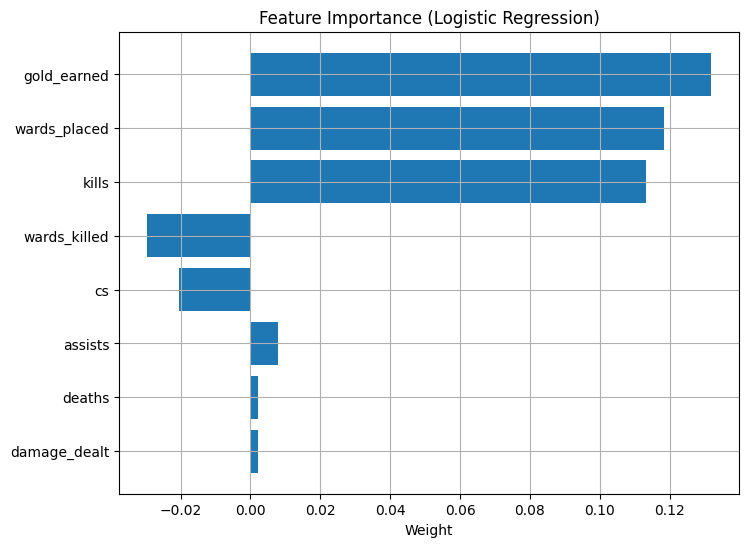

        Feature  Importance
7  damage_dealt    0.002093
1        deaths    0.002137
2       assists    0.007783
4            cs   -0.020324
6  wards_killed   -0.029521
0         kills    0.113205
5  wards_placed    0.118395
3   gold_earned    0.131786


In [44]:
feature_importance = model_l2.linear.weight.data.numpy().flatten()  # Extract weights from trained model

importance_df = pd.DataFrame({  # Create DataFrame for feature importance
    'Feature': X.columns,  # Feature names
    'Importance': feature_importance  # Corresponding weights
})

importance_df['AbsImportance'] = importance_df['Importance'].abs()  # Add absolute value for sorting
importance_df = importance_df.sort_values(by='AbsImportance', ascending=True)  # Sort by absolute importance

plt.figure(figsize=(8, 6))  # Set figure size
plt.barh(importance_df['Feature'], importance_df['Importance'])  # Horizontal bar plot
plt.xlabel('Weight')  # X-axis label
plt.title('Feature Importance (Logistic Regression)')  # Plot title
plt.grid(True)  # Show grid
plt.show()  # Display plot

print(importance_df[['Feature', 'Importance']])  # Print feature importance table